# Metadrive Intro

We now introduce the environment we will be using for this notebook: [Metadrive](https://github.com/metadriverse/metadrive)

Check out the notebook [here](../quickstart.ipynb) for a quick introduction to Metadrive as well as how to install it.

Let's get started by doing a bunch of imports.

In [31]:
# We need to import metadrive to register the environments
import metadrive
import gymnasium as gym
import typing
import numpy as np
import numpy.typing as npt
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass


Let's test out the environment by creating an instance of it and taking a random action at each timestep.

In [32]:
# horizon represents the number of steps in an episode before truncation
env = gym.make("MetaDrive-validation-v0", config={"use_render": True, "horizon": 100})
env.reset()
while True:
    obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
    if terminated or truncated:
        break
env.close()

/home/fidgetsinner/venvs/metadrive/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:210: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


## Gymnasium Environment

Metadrive uses the [Farama Gymnasium](https://gymnasium.farama.org/), which has a standard API for interacting with environments. There are a couple of functions and properties that are good to know about:
1. `reset()`: Resets the environment to its initial state and returns the initial observation.
    * Documentation: https://gymnasium.farama.org/api/env/#gymnasium.Env.reset
2. `step(action)`: Takes an action and returns the next observation, the reward for taking the action, whether the episode is terminated, whether the episode is truncated (ran out of time), and any additional information.
    * Documentation: https://gymnasium.farama.org/api/env/#gymnasium.Env.step
3. `close()`: Closes the environment.
    * Documentation: https://gymnasium.farama.org/api/env/#g1ymnasium.Env.close
4. `action_space`: The action space of the environment, which tells us the shape and bounds of the action space.
    * Documentation: https://gymnasium.farama.org/api/env/#gymnasium.Env.action_space
5. `observation_space`: The observation space of the environment, which tells us the shape and bounds of the observation space.
    * Documentation: https://gymnasium.farama.org/api/env/#gymnasium.Env.observation_space

Let's take a closer look at what our observation and action spaces are:

In [33]:
env = gym.make("MetaDrive-validation-v0", config={"use_render": False, "horizon": 100})
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)
env.close()

Observation Space: Box(-0.0, 1.0, (259,), float32)
Action Space: Box(-1.0, 1.0, (2,), float32)


Box spaces represent a continuous space. As the documentation states, a Box represents the Cartesian product of $n$ closed intervals.

For our observation space, we have a 259 dimensional vector, where each element is in the range $[0.0, 1.0]$.
* Documentation: https://metadrive-simulator.readthedocs.io/en/latest/observation.html

For the action space, we have a 2 dimensional vector, where each element is in the range $[-1.0, 1.0]$. The first element represents the steering angle, and the second element represents the throttle.
* Documentation: https://metadrive-simulator.readthedocs.io/en/latest/action_and_dynamics.html


# Implementation

Now that we've seen what the environment looks like, let's implement REINFORCE.

The REINFORCE algorithm is as follows:
1. Initialize the policy parameters $\theta$.
2. Create an initially empty set of trajectories $D$.
3. Create a trajectory $\tau = (s_1, a_1, r_1, \ldots, s_T, a_T, r_T)$ by running the policy $\pi_\theta$ in the environment and append it to $D$.
4. Compute the return $\hat{R}_t$ for each timestep $t$ in the trajectory.
5. Repeat steps 2-4 until $|D| = N$.
6. Compute the policy gradient estimate $\hat{g} = \frac{1}{N} \sum_{i=1}^N \sum_{t=1}^{T_i} \nabla_\theta \log \pi_\theta(a_{i,t} | s_{i,t}) \hat{R}_t$.
7. Update the policy parameters $\theta \leftarrow \theta + \alpha \hat{g}$.
8. Repeat steps 2-7 until the policy converges.

All things considered, this is a pretty simple algorithm. Let's implement it!

## Collecting Trajectories

There's one problem you might see here: we previously stated that we were focusing on the discrete case. This means our policy will produce discrete actions. However, our action space seems to be continuous.

How can we solve this problem?

Our solution is going to be to **discretize** our action space. This means that we will provide a finite number of actions, and each action corresponds to a fixed vector of real numbers.

We will discretize the steering angle into 2 bins, and the throttle into 2 bins. This will give us a total of 4 actions. We'll write a function to convert our discrete action into a continuous action, which we can provide to the environment.

In [52]:
NUM_ACTIONS = 4

def discrete2continuous(action:int) -> npt.NDArray[np.float32]:
    """
    Convert discrete action to continuous action
    """
    assert 0 <= action < 4
    throttle_magnitude = 1.0
    brake_magnitude = 1.0
    steering_magnitude = 1.0
    match action:
        case 0:
            return np.array([steering_magnitude, 0.0])
        case 1:
            return np.array([0.0, throttle_magnitude])
        case 2:
            return np.array([0.0, -brake_magnitude])
        case 3:
            return np.array([-steering_magnitude, 0.0])


With this discretization function, we can write a function to collect a trajectory given a policy.

In [35]:
def collect_trajectory(env:gym.Env, policy:typing.Callable[[npt.NDArray], int]) -> tuple[list[npt.NDArray], list[int], list[float]]:
    """
    Collect a trajectory from the environment using the given policy
    """
    observations = []
    actions = []
    rewards = []
    obs, info = env.reset()
    
    while True:
        observations.append(obs)
        action = policy(obs)
        actions.append(action)
        obs, reward, terminated, truncated, info = env.step(discrete2continuous(action))
        rewards.append(reward)
        if terminated or truncated:
            break

    return observations, actions, rewards

Note that we define a policy as any function that takes in an observation and returns an action. This means that we can be more general than just using a neural net as a policy.
For example, let's first test out our `collect_trajectory` function with a random policy:

In [36]:
env = gym.make("MetaDrive-validation-v0", config={"use_render": False, "horizon": 100})
# horizon is the max number of steps in a trajectory
def random_policy(obs:npt.NDArray) -> int:
    """
    A random policy that returns a random action
    """
    return np.random.randint(0, NUM_ACTIONS)

obs, actions, rewards = collect_trajectory(env, random_policy)

# print the first 10 observations, actions, and rewards
print("Observations:", obs[:10])
print("Actions:", actions[:10])
print("Rewards:", rewards[:10])
env.close()

:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


Observations: [array([0.09722222, 0.4861111 , 0.5       , 0.01234568, 0.5       ,
       0.5       , 0.5       , 0.        , 0.5       , 0.55      ,
       0.465     , 0.        , 0.5       , 0.5       , 0.95      ,
       0.46500003, 0.        , 0.5       , 0.5       , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.  

## Reward-to-go

Our `collect_trajectory` function allows us to gather rewards from the trajectory. However, recall that what we'll actually train the network on is the reward-to-go. Let's now create the function `reward_to_go` to compute the reward-to-go for each timestep in the trajectory.

In [37]:
def rewards_to_go(trajectory_rewards: list[float], gamma) -> list[float]:
    """
    Computes the gamma discounted reward-to-go for each state in the trajectory.
    """

    trajectory_len = len(trajectory_rewards)

    v_batch = np.zeros(trajectory_len)

    v_batch[-1] = trajectory_rewards[-1]

    # Use gamma to decay the advantage
    for t in reversed(range(trajectory_len - 1)):
        v_batch[t] = trajectory_rewards[t] + gamma * v_batch[t + 1]

    return list(v_batch)

## Policy Network

So, now that we have a function that lets us go from policies to trajectories, we should work on creating a neural network based policy. The network should take in an observation, and return a probability for each number between 0 and 9.

We're going to keep the network fairly small for now.

In [38]:
# policy network
class Policy(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(259, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, NUM_ACTIONS)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        # output in (Batch, Width)
        output = F.softmax(x, dim=1)
        return output

Let's define a policy function that allows us to sample an action:

In [39]:
def deviceof(m: nn.Module) -> torch.device:
    """
    Get the device of the given module
    """
    return next(m.parameters()).device

def nn_policy(net:Policy, obs:npt.NDArray) -> int:
    """
    A neural network policy that returns an action based on the given observation
    """
    # convert observation to a tensor
    obs_tensor = torch.from_numpy(obs).float().to(deviceof(net))
    # add batch dimension
    obs_tensor = obs_tensor.unsqueeze(0)
    # get the action probabilities
    action_probs = net(obs_tensor)
    # sample an action from the action probabilities
    action = torch.multinomial(action_probs, 1)
    return action.item()

Let's test it out (untrained)

In [40]:
env = gym.make("MetaDrive-validation-v0", config={"use_render": False, "horizon": 100})

policy = Policy()
obs, actions, rewards = collect_trajectory(env, lambda obs: nn_policy(policy, obs))
# print the first 10 observations, actions, and rewards
print("Observations:", obs[:10])
print("Actions:", actions[:10])
print("Rewards:", rewards[:10])

env.close()

:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


Observations: [array([0.09722222, 0.4861111 , 0.5       , 0.01234568, 0.5       ,
       0.5       , 0.5       , 0.        , 0.5       , 0.55      ,
       0.465     , 0.        , 0.5       , 0.5       , 0.95      ,
       0.46500003, 0.        , 0.5       , 0.5       , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.  

As you can see, it performs basically random actions, since it hasn't been trained yet.

## Computing the Policy Gradient

Let's now work on the meat of the problem: computing the policy gradient

In [41]:
@dataclass
class PolicyGradientConfig:
    entropy_bonus: float

def compute_policy_gradient_loss(
    # Current policy network's probability of choosing an action
    # in (Batch, Action)
    pi_theta_given_st: torch.Tensor,
    # One hot encoding of which action was chosen
    # in (Batch, Action)
    a_t: torch.Tensor,
    # Rewards To Go for the chosen action
    # in (Batch,)
    R_t: torch.Tensor,
    # config
    config: PolicyGradientConfig,
) -> torch.Tensor:
    r"""
    Computes the policy gradient loss for a vector of examples, and reduces with mean.

    The standard policy gradient is given by the expected value over trajectories of:

    :math:`\sum_{t=0}^{T} \nabla_{\theta} (\log \pi_{\theta}(a_t|s_t))R_t`
    
    where:
    * :math:`\pi_{\theta}(a_t|s_t)` is the current policy's probability to perform action :math:`a_t` given :math:`s_t`
    * :math:`R_t` is the rewards-to-go from the state at time t to the end of the episode from which it came.
    """

    # here, the multiplication and sum is in order to extract the
    # in (Batch,)
    pi_theta_at_given_st = torch.sum(pi_theta_given_st * a_t, 1)

    # Note: this loss has doesn't actually represent whether the action was good or bad
    # it is a dummy loss, that is only used to compute the gradient

    # Recall that the policy gradient for a single transition (state-action pair) is given by:
    # $\nabla_{\theta} \log \pi_{\theta}(a_t|s_t)R_t$
    # However, it's easier to work with losses, rather than raw gradients.
    # Therefore we construct a loss, that when differentiated, gives us the policy gradient.
    # this loss is given by:
    # $-\log \pi_{\theta}(a_t|s_t)R_t$

    # in (Batch,)
    policy_loss_per_example = -torch.log(pi_theta_at_given_st) * R_t

    # in (Batch,)
    entropy_per_example = -torch.sum(
        torch.log(pi_theta_given_st) * pi_theta_given_st, 1
    )

    # we reward entropy, since excessive certainty indicate the model is 'overfitting'
    loss_per_example = policy_loss_per_example - config.entropy_bonus * entropy_per_example

    # we take the average loss over all examples
    return loss_per_example.mean()


def train_policygradient(
    policy: Policy,
    policy_optimizer: torch.optim.Optimizer,
    observation_batch: list[npt.NDArray],
    action_batch: list[int],
    rtg_batch: list[float],
    config: PolicyGradientConfig,
) -> float:
    # assert that the batch_lengths are the same
    assert len(observation_batch) == len(action_batch)
    assert len(observation_batch) == len(rtg_batch)

    # get device
    device = deviceof(policy)

    # convert data to tensors on correct device

    # in (Batch, Width)
    observation_batch_tensor = torch.from_numpy(np.stack(observation_batch)).to(device)

    # in (Batch,)
    rtg_batch_tensor = torch.tensor(
        rtg_batch, dtype=torch.float32, device=device
    )

    # in (Batch, Action)
    chosen_action_tensor = F.one_hot(
        torch.tensor(action_batch).to(device).long(), num_classes=NUM_ACTIONS
    )

    # train policy network
    policy_optimizer.zero_grad()
    action_probs = policy.forward(observation_batch_tensor)
    policy_loss = compute_policy_gradient_loss(
        action_probs, chosen_action_tensor, rtg_batch_tensor, config
    )
    policy_loss.backward()
    policy_optimizer.step()

    # return the respective losses
    return policy_loss.item()


## Training the Policy Network

With that, we're done. Let's train!

In [42]:
# disable logging from metadrive
import logging
import inspect
logging.getLogger(inspect.getfile(metadrive.envs.base_env)).setLevel(logging.WARNING)

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

policy = Policy().to(device)
policy_optimizer = torch.optim.Adam(policy.parameters(), lr=1e-4)
policy_scheduler = torch.optim.lr_scheduler.StepLR(policy_optimizer, step_size=1, gamma=0.97)

step = 0
return_means = []
return_stds = []
return_medians = []
losses = []

In [55]:
env = gym.make("MetaDrive-validation-v0", config={"use_render": False, "horizon": 500})

In [56]:
TRAIN_EPOCHS = 150
EPISODES_PER_BATCH = 32
GAMMA = 0.90
CONFIG = PolicyGradientConfig(entropy_bonus=0.10)

# Train
while step < TRAIN_EPOCHS:
    obs_batch:list[npt.NDArray[np.float32]] = []
    act_batch:list[int] = []
    rtg_batch:list[float] = []
    
    trajectory_returns = []

    for _ in range(EPISODES_PER_BATCH):
        # Collect trajectory
        obs_traj, act_traj, rew_traj = collect_trajectory(env, lambda obs: nn_policy(policy, obs))
        rtg_traj = rewards_to_go(rew_traj, GAMMA)

        # Update batch
        obs_batch.extend(obs_traj)
        act_batch.extend(act_traj)
        rtg_batch.extend(rtg_traj)

        # Update trajectory returns
        trajectory_returns.append(sum(rew_traj))

    policy_loss = train_policygradient(
        policy,
        policy_optimizer,
        obs_batch,
        act_batch,
        rtg_batch,
        CONFIG,
    )
    policy_scheduler.step()

    # collect statistics
    return_means.append(np.mean(trajectory_returns))
    return_stds.append(np.std(trajectory_returns))
    return_medians.append(np.median(trajectory_returns))
    losses.append(policy_loss)

    print(f"Step {step}, Policy Loss: {policy_loss:.3f}, Avg. Returns: {np.mean(trajectory_returns):.3f}")

    step += 1

:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


Step 0, Policy Loss: 0.027, Avg. Returns: 1.309
Step 1, Policy Loss: 0.022, Avg. Returns: 1.272
Step 2, Policy Loss: 0.028, Avg. Returns: 1.339
Step 3, Policy Loss: 0.056, Avg. Returns: 1.571
Step 4, Policy Loss: 0.057, Avg. Returns: 1.551
Step 5, Policy Loss: 0.120, Avg. Returns: 2.078
Step 6, Policy Loss: 0.101, Avg. Returns: 1.967
Step 7, Policy Loss: 0.090, Avg. Returns: 1.842
Step 8, Policy Loss: 0.163, Avg. Returns: 2.462
Step 9, Policy Loss: 0.140, Avg. Returns: 2.291
Step 10, Policy Loss: 0.153, Avg. Returns: 2.413
Step 11, Policy Loss: 0.202, Avg. Returns: 2.784
Step 12, Policy Loss: 0.183, Avg. Returns: 2.585
Step 13, Policy Loss: 0.168, Avg. Returns: 2.472
Step 14, Policy Loss: 0.237, Avg. Returns: 3.179
Step 15, Policy Loss: 0.220, Avg. Returns: 3.016
Step 16, Policy Loss: 0.291, Avg. Returns: 3.628
Step 17, Policy Loss: 0.259, Avg. Returns: 3.427
Step 18, Policy Loss: 0.304, Avg. Returns: 3.783
Step 19, Policy Loss: 0.325, Avg. Returns: 4.087
Step 20, Policy Loss: 0.302, A

KeyboardInterrupt: 

In [59]:
env.close()

Let's visualize how the policy drives:

In [60]:
env = gym.make("MetaDrive-validation-v0", config={"use_render": True, "horizon": 500})
obs, act, rew = collect_trajectory(env, lambda obs: nn_policy(policy, obs))
env.close()

print("Reward:", sum(rew))

Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


Reward: 69.58637219989039


For us, we got returns of around 12-14 after training.

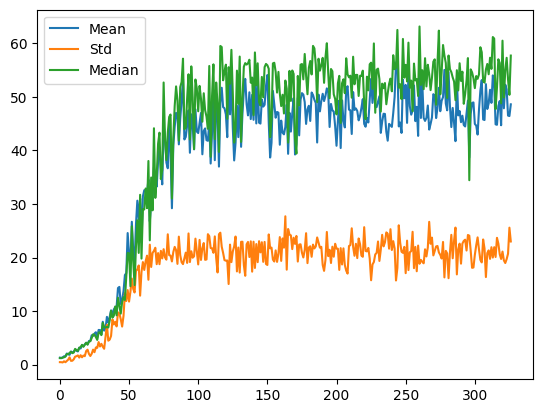

In [58]:
# plot data
import matplotlib.pyplot as plt
plt.plot(return_means, label="Mean")
plt.plot(return_stds, label="Std")
plt.plot(return_medians, label="Median")
plt.legend()